In [1]:
import pandas as pd
import numpy as np
import spacy
import string
from spacy.lang.en import English

from preprocessing import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
import sklearn

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Open data

In [2]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_lg')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [3]:
df = pd.read_csv('TrainingDS.csv')
prep_train = PrepareText(df, spell_correct=True, remove_punct=False)
prep_train.prepare()
prep_train.save_file('prep_train.csv')
df = prep_train.df

df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
prep_test = PrepareText(df_test, spell_correct=True, remove_punct=False)
prep_test.prepare()
prep_test.save_file('prep_test.csv')
df_test = prep_test.df
df

preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL
preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL


,ID,Text,Class
0,1,trump supporters needed 4 democrats socialist ...,0
1,2,send back!!why hell im sick hearing ifwe great...,1
2,3,yeah... im wondering send works wife camp 3 kn...,1
3,4,know realize cant pretend didnt know obama beg...,1
4,5,donny owe people apology applauding horrible c...,0
...,...,...,...
1495,1496,white person migrated obviously hated america ...,1
1496,1497,talk 1 hes dumbass texts 2 love mean 3 dick du...,0
1497,1498,send love leave different things,1
1498,1499,trump wants end racist chants needs repeat sen...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1500 non-null   int64 
 1   Text    1500 non-null   object
 2   Class   1500 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 35.3+ KB


In [5]:
df.describe()

,ID,Class
count,1500.000000,1500.000000
mean,750.500000,0.386667
std,433.157015,0.487149
min,1.000000,0.000000
25%,375.750000,0.000000
50%,750.500000,0.000000
75%,1125.250000,1.000000
max,1500.000000,1.000000


Balance

In [6]:
df['Class'].value_counts()

0    920
1    580
Name: Class, dtype: int64

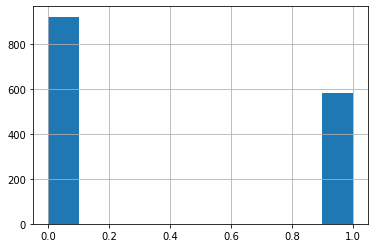

In [7]:
_ = df['Class'].hist()

# Baseline

Get embedding

In [8]:
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in df['Text']])
    
doc_vectors.shape

(1500, 300)

Splitting data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, df['Class'],
                                                    test_size=0.1, random_state=1)

LinearSVC

In [10]:
svc = LinearSVC(random_state=1)
svc.fit(X_train, y_train)
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )
svc.fit(doc_vectors, df['Class'])

Accuracy: 79.333%


LinearSVC(random_state=1)

### Predict test

In [11]:
df_sample.head()

,ID,Class
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
df_test.head()

,ID,Text,Class
0,1,ye bhi illegal immigrant lag rah hai arc regis...,?
1,2,yeah asked skirt today said ass like don't tim...,?
2,3,need clean selective hearing cobwebs ears tell...,?
3,4,easy complain criticize offering solution clos...,?
4,5,guess send-them-back policy friend hit little ...,?


In [13]:
with nlp.disable_pipes():
    doc_vectors_test = np.array([nlp(text).vector for text in df_test.Text])
doc_vectors_test.shape

(500, 300)

In [14]:
predict = svc.predict(doc_vectors_test)
predict[:5]

array([1, 1, 0, 1, 0], dtype=int64)

In [15]:
df_test['Class'] = predict
df_test.head()

,ID,Text,Class
0,1,ye bhi illegal immigrant lag rah hai arc regis...,1
1,2,yeah asked skirt today said ass like don't tim...,1
2,3,need clean selective hearing cobwebs ears tell...,0
3,4,easy complain criticize offering solution clos...,1
4,5,guess send-them-back policy friend hit little ...,0


In [16]:
df_test.drop('Text', axis=1).to_csv('test_predict.csv', index=False, sep=',')

Kaggle score: 0.76

# Prepare data

In [17]:
test_text = df.iloc[0]['Text']
print(test_text)

trump supporters needed 4 democrats socialist squad racist trump america supporters america freedom speech trump hyper rally socialist democratic squad rally rally said send migrants socialist democratic


In [18]:
#RandomOverSampler - for imbalanced target 

tokenizer

In [19]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

Custom Transformer

In [20]:
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

TF-IDF and Bag of Words transformers

In [21]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3, ngram_range=(1,2))

Split data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], 
    df['Class'], 
    test_size=0.2, 
    stratify=df['Class'], 
    random_state=42
)

In [23]:
def saveTest(pipe, df_test, name_file):
    pipe.fit(df['Text'], df['Class'])
    predict = pipe.predict(df_test['Text'])
    df_test['Class'] = predict
    df_test.drop('Text', axis=1).to_csv(name_file+'.csv', index=False, sep=',')
    print('Complete')

<b>Creating a Pipeline and Generating the Model</b>

TF-IDF

In [24]:
classifier = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=5)
classifier = LogisticRegression(
    random_state=42, 
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=.05,
    max_iter=200
) # kaggle 0.81 0.84

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('RUS', RandomOverSampler()),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)

# Model Accuracy
print("TF-IDF Accuracy: \t", sklearn.metrics.accuracy_score(y_test, predicted))
print("TF-IDF Precision: \t", sklearn.metrics.precision_score(y_test, predicted))
print("TF-IDF Recall: \t\t", sklearn.metrics.recall_score(y_test, predicted))
print("TF-IDF f1: \t\t", sklearn.metrics.f1_score(y_test, predicted))

TF-IDF Accuracy: 	 0.86
TF-IDF Precision: 	 0.8032786885245902
TF-IDF Recall: 		 0.8448275862068966
TF-IDF f1: 		 0.823529411764706


In [25]:
saveTest(pipe, df_test, 'test_predict2')

Complete


Bag of word

In [26]:
pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('RUS', RandomOverSampler()),
                 ('classifier', classifier)])

# model generation
pipe2.fit(X_train,y_train)
predicted = pipe2.predict(X_test)

# Model Accuracy
print("Bag of Words Accuracy: \t", sklearn.metrics.accuracy_score(y_test, predicted))
print("Bag of Words Precision: ", sklearn.metrics.precision_score(y_test, predicted))
print("Bag of Words Recall: \t", sklearn.metrics.recall_score(y_test, predicted))
print("Bag of Words f1: \t", sklearn.metrics.f1_score(y_test, predicted))

Bag of Words Accuracy: 	 0.86
Bag of Words Precision:  0.8032786885245902
Bag of Words Recall: 	 0.8448275862068966
Bag of Words f1: 	 0.823529411764706


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [27]:
saveTest(pipe, df_test, 'test_predict3')

Complete


- logreg TF-IDF = 0.82666
- logreg Bog = 0.83500

Embeddings